In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [10]:
target = df['DEATH_EVENT'].apply(str)
df = df.drop('DEATH_EVENT', axis=1)

scaler = StandardScaler()
df = scaler.fit_transform(df)

df

array([[ 1.19294523e+00, -8.71104775e-01,  1.65728387e-04, ...,
         7.35688190e-01, -6.87681906e-01, -1.62950241e+00],
       [-4.91279276e-01, -8.71104775e-01,  7.51463953e+00, ...,
         7.35688190e-01, -6.87681906e-01, -1.60369074e+00],
       [ 3.50832977e-01, -8.71104775e-01, -4.49938761e-01, ...,
         7.35688190e-01,  1.45416070e+00, -1.59078490e+00],
       ...,
       [-1.33339153e+00, -8.71104775e-01,  1.52597865e+00, ...,
        -1.35927151e+00, -6.87681906e-01,  1.90669738e+00],
       [-1.33339153e+00, -8.71104775e-01,  1.89039811e+00, ...,
         7.35688190e-01,  1.45416070e+00,  1.93250906e+00],
       [-9.12335403e-01, -8.71104775e-01, -3.98321274e-01, ...,
         7.35688190e-01,  1.45416070e+00,  1.99703825e+00]])

In [11]:
from LinearRegressionClassifier import LinearRegressionClassifier
from GDClassifier import GDClassifier
from SVMClassifier import SVMClassifier

X_train, X_test, y_train, y_test = train_test_split(df, target.values, train_size=0.7)

n = len(X_train)
epochs = n * 4

model_gd = GDClassifier(
    lr=0.001,
    epochs=epochs,
    loss_function='sigmoid',
    regularization='ridge',
    beta=50
)

model_gd.fit(X_train, y_train)
prediction = model_gd.predict(X_test)

gd_score = accuracy_score(y_test, prediction)
gd_score

0.7888888888888889

In [12]:
model_reg = LinearRegressionClassifier(tau=50)

model_reg.fit(X_train, y_train)
prediction = model_reg.predict(X_test)

reg_score = accuracy_score(y_test, prediction)
reg_score

0.7666666666666667

In [13]:
model_svm = SVMClassifier(C=1.5, epochs=epochs, max_passes=3)

model_svm.fit(X_train, y_train)
prediction = model_svm.predict(X_test)

svm_score = accuracy_score(y_test, prediction)
svm_score

0.7777777777777778

In [14]:
import optuna
from sklearn.model_selection import cross_val_score

def regression_objective(trial):
    tau = trial.suggest_int('tau', 0, 250, step=5)
    score = cross_val_score(
        LinearRegressionClassifier(tau=tau), X_train, y_train, scoring='accuracy', n_jobs=10
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(regression_objective, n_trials=50)

[I 2024-05-09 02:01:12,544] A new study created in memory with name: no-name-02e527e0-e08f-4b02-8667-85d0e4a343da
[I 2024-05-09 02:01:12,569] Trial 0 finished with value: 0.8326364692218352 and parameters: {'tau': 95}. Best is trial 0 with value: 0.8326364692218352.
[I 2024-05-09 02:01:12,584] Trial 1 finished with value: 0.8326364692218352 and parameters: {'tau': 80}. Best is trial 0 with value: 0.8326364692218352.
[I 2024-05-09 02:01:12,600] Trial 2 finished with value: 0.8089430894308943 and parameters: {'tau': 130}. Best is trial 0 with value: 0.8326364692218352.
[I 2024-05-09 02:01:12,615] Trial 3 finished with value: 0.8279907084785133 and parameters: {'tau': 115}. Best is trial 0 with value: 0.8326364692218352.
[I 2024-05-09 02:01:12,630] Trial 4 finished with value: 0.8326364692218352 and parameters: {'tau': 55}. Best is trial 0 with value: 0.8326364692218352.
[I 2024-05-09 02:01:12,646] Trial 5 finished with value: 0.832752613240418 and parameters: {'tau': 105}. Best is trial 

In [15]:
reg_params = study.best_params
study.best_value, reg_params

(0.8421602787456447, {'tau': 20})

In [16]:
def gd_objective(trial):
    lr = trial.suggest_float('lr', 0.0001, 0.0101, step=0.0002)
    loss_function = trial.suggest_categorical('loss_function', ['mse', 'log', 'sigmoid'])
    regularization = trial.suggest_categorical('regularization', [None, 'lasso', 'ridge', 'elastic'])
    if regularization is None:
        alpha = 0
        beta = 0
    elif regularization == 'lasso':
        alpha = trial.suggest_int('alpha', 1, 251, step=5)
        beta = 0
    elif regularization == 'ridge':
        alpha = 0
        beta = trial.suggest_int('beta', 1, 251, step=5)
    else:
        alpha = trial.suggest_int('alpha', 1, 251, step=5)
        beta = trial.suggest_int('beta', 1, 251, step=5)
    classifier = GDClassifier(
        lr=lr,
        epochs=epochs,
        loss_function=loss_function,
        regularization=regularization,
        alpha=alpha,
        beta=beta
    )
    score = cross_val_score(
        classifier, X_train, y_train, scoring='accuracy', n_jobs=10
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(gd_objective, n_trials=50)

[I 2024-05-09 02:01:13,976] A new study created in memory with name: no-name-bab30f10-ac1c-49f0-ba3d-2f021784b5bc
[I 2024-05-09 02:01:15,231] Trial 0 finished with value: 0.8231126596980255 and parameters: {'lr': 0.0023, 'loss_function': 'log', 'regularization': 'ridge', 'beta': 171}. Best is trial 0 with value: 0.8231126596980255.
[I 2024-05-09 02:01:16,351] Trial 1 finished with value: 0.32497096399535425 and parameters: {'lr': 0.0047, 'loss_function': 'mse', 'regularization': 'elastic', 'alpha': 211, 'beta': 246}. Best is trial 0 with value: 0.8231126596980255.
[I 2024-05-09 02:01:17,612] Trial 2 finished with value: 0.8231126596980255 and parameters: {'lr': 0.0067, 'loss_function': 'log', 'regularization': 'ridge', 'beta': 186}. Best is trial 0 with value: 0.8231126596980255.
[I 2024-05-09 02:01:18,742] Trial 3 finished with value: 0.32497096399535425 and parameters: {'lr': 0.0093, 'loss_function': 'mse', 'regularization': 'elastic', 'alpha': 21, 'beta': 206}. Best is trial 0 with 

In [17]:
gd_params = study.best_params
study.best_value, gd_params

(0.83739837398374,
 {'lr': 0.0037, 'loss_function': 'log', 'regularization': 'ridge', 'beta': 46})

In [18]:
def svm_objective(trial):
    C = trial.suggest_float('C', 0.1, 2.0, step=0.1)
    max_passes = trial.suggest_int('max_passes', 1, 5, step=1)
    kernel = trial.suggest_categorical('kernel', [None, 'sqr', 'sigmoid', 'radial'])
    if kernel is not None and kernel == 'radial':
        beta = trial.suggest_float('beta', 1, 101, step=2)
    else:
        beta = 0
    classifier = SVMClassifier(C=C, max_passes=max_passes, epochs=epochs, kernel=kernel, beta=beta)
    score = cross_val_score(
        classifier, X_train, y_train, scoring='accuracy', n_jobs=10
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(svm_objective, n_trials=50, n_jobs=10)

[I 2024-05-09 02:02:21,252] A new study created in memory with name: no-name-cd99b122-cb81-4f3c-8abc-c1234f660917
[I 2024-05-09 02:02:25,996] Trial 2 finished with value: 0.6750290360046458 and parameters: {'C': 2.0, 'max_passes': 4, 'kernel': 'radial', 'beta': 31.0}. Best is trial 2 with value: 0.6750290360046458.
[I 2024-05-09 02:02:27,256] Trial 0 finished with value: 0.6750290360046458 and parameters: {'C': 1.3000000000000003, 'max_passes': 3, 'kernel': 'radial', 'beta': 25.0}. Best is trial 2 with value: 0.6750290360046458.
[I 2024-05-09 02:02:30,095] Trial 1 finished with value: 0.6845528455284553 and parameters: {'C': 1.4000000000000001, 'max_passes': 4, 'kernel': None}. Best is trial 1 with value: 0.6845528455284553.
[I 2024-05-09 02:02:34,077] Trial 5 finished with value: 0.8040650406504065 and parameters: {'C': 1.5000000000000002, 'max_passes': 5, 'kernel': None}. Best is trial 5 with value: 0.8040650406504065.
[I 2024-05-09 02:02:35,451] Trial 4 finished with value: 0.761091

In [19]:
svm_params = study.best_params
study.best_value, svm_params

(0.8422764227642278, {'C': 0.5, 'max_passes': 4, 'kernel': None})

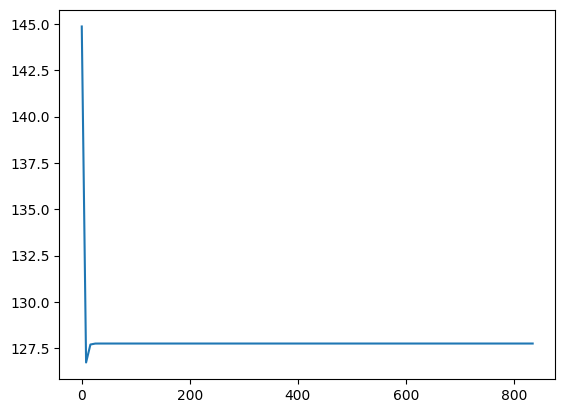

In [20]:
# train loss curve

import matplotlib.pyplot as plt
import numpy as np

model_gd = GDClassifier(epochs=epochs, track_loss=True, **gd_params)
model_gd.fit(X_train, y_train)
curve_indices = np.linspace(0, model_gd.completed_epochs - 1, 100, dtype=int)
plt.plot(curve_indices, np.array(model_gd.loss_values)[curve_indices])
plt.show()

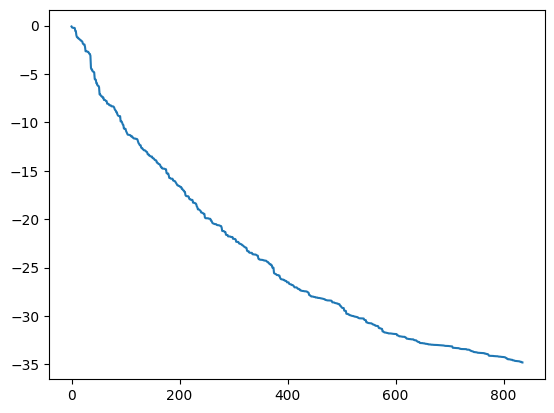

In [21]:
model_svm = SVMClassifier(epochs=epochs, track_loss=True, **svm_params)
model_svm.fit(X_train, y_train)
plt.plot(range(model_svm.completed_epochs), model_svm.loss_values)
plt.show()

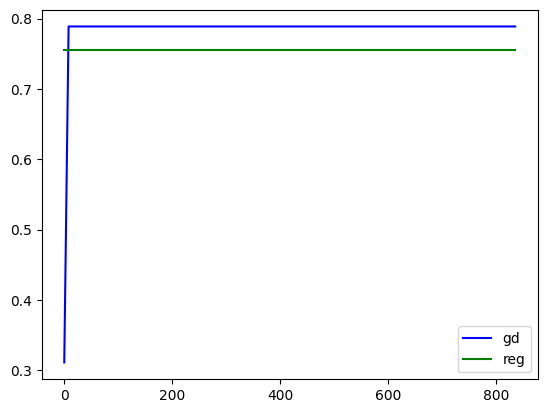

In [22]:
# model score curve

model_reg = LinearRegressionClassifier(**reg_params)
model_reg.fit(X_train, y_train)
prediction = model_reg.predict(X_test)
reg_score = accuracy_score(y_test, prediction)

model_gd = GDClassifier(epochs=epochs, track_score=True, **gd_params)
model_gd.fit(X_train, y_train, X_test=X_test, y_test=y_test)
curve_indices = np.linspace(0, model_gd.completed_epochs - 1, 100, dtype=int)
plt.plot(curve_indices, np.array(model_gd.score_values)[curve_indices], c='b', label='gd')
plt.plot(curve_indices, list(map(lambda _: reg_score, curve_indices)), c='g', label='reg')
plt.legend()
plt.show()

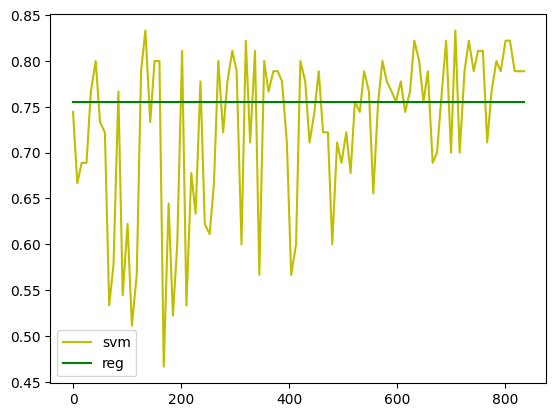

In [23]:
model_svm = SVMClassifier(epochs=epochs, track_score=True, **svm_params)
model_svm.fit(X_train, y_train, X_test=X_test, y_test=y_test)
curve_indices = np.linspace(0, model_svm.completed_epochs - 1, 100, dtype=int)
plt.plot(curve_indices, np.array(model_svm.score_values)[curve_indices], c='y', label='svm')
plt.plot(curve_indices, list(map(lambda _: reg_score, curve_indices)), c='g', label='reg')
plt.legend()
plt.show()

In [28]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.svm import SVC

lib_reg = RidgeClassifier(alpha=50)
lib_reg.fit(X_train, y_train)
lib_reg.score(X_test, y_test)

0.7666666666666667

In [44]:
lib_gd = SGDClassifier(
    learning_rate='constant',
    loss='perceptron',
    eta0=0.001,
    max_iter=epochs,
    alpha=50
)
lib_gd.fit(X_train, y_train)
lib_gd.score(X_test, y_test)

0.7888888888888889

In [68]:
lib_svm = SVC(
    C=1.5,
    max_iter=epochs,
    kernel='linear'
)
lib_svm.fit(X_train, y_train)
lib_svm.score(X_test, y_test)

C:\Users\mi\PycharmProjects\machine-learning\venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=836).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.8111111111111111

In [48]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.0, 250.0, step=5)
    score = cross_val_score(
        RidgeClassifier(alpha=alpha), X_train, y_train
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-09 04:30:12,002] A new study created in memory with name: no-name-2e952360-5ac4-4e96-ab40-2317ab77a942
[I 2024-05-09 04:30:12,023] Trial 0 finished with value: 0.7847851335656214 and parameters: {'alpha': 240.0}. Best is trial 0 with value: 0.7847851335656214.
[I 2024-05-09 04:30:12,039] Trial 1 finished with value: 0.8277584204413472 and parameters: {'alpha': 25.0}. Best is trial 1 with value: 0.8277584204413472.
[I 2024-05-09 04:30:12,053] Trial 2 finished with value: 0.7847851335656214 and parameters: {'alpha': 235.0}. Best is trial 1 with value: 0.8277584204413472.
[I 2024-05-09 04:30:12,070] Trial 3 finished with value: 0.8229965156794424 and parameters: {'alpha': 105.0}. Best is trial 1 with value: 0.8277584204413472.
[I 2024-05-09 04:30:12,087] Trial 4 finished with value: 0.8229965156794424 and parameters: {'alpha': 125.0}. Best is trial 1 with value: 0.8277584204413472.
[I 2024-05-09 04:30:12,107] Trial 5 finished with value: 0.8325203252032521 and parameters: {'alp

In [50]:
lib_reg_params = study.best_params
study.best_value, lib_reg_params

(0.8372822299651567, {'alpha': 0.0})

In [59]:
def objective(trial):
    eta0 = trial.suggest_float('eta0', 0.0001, 0.0101, step=0.0002)
    loss = trial.suggest_categorical('loss', ['log_loss', 'perceptron', 'squared_error'])
    penalty = trial.suggest_categorical('penalty', [None, 'l1', 'l2', 'elasticnet'])
    if penalty is not None:
        alpha = trial.suggest_int('alpha', 1, 251, step=5)
    else:
        alpha = 0
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0, step=0.05)
    else:
        l1_ratio = 0
    classifier = SGDClassifier(
        loss=loss,
        penalty=penalty,
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=epochs,
        learning_rate='constant',
        eta0=eta0
    )
    score = cross_val_score(
        classifier, X_train, y_train
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-09 14:09:21,050] A new study created in memory with name: no-name-ddadc52a-f8bd-46ae-a7a0-d0e77e52a89f
[I 2024-05-09 14:09:21,072] Trial 0 finished with value: 0.6746806039488967 and parameters: {'eta0': 0.0071, 'loss': 'log_loss', 'penalty': 'l1', 'alpha': 11}. Best is trial 0 with value: 0.6746806039488967.
[I 2024-05-09 14:09:21,087] Trial 1 finished with value: 0.6746806039488967 and parameters: {'eta0': 0.005900000000000001, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 81, 'l1_ratio': 0.9500000000000001}. Best is trial 0 with value: 0.6746806039488967.
[I 2024-05-09 14:09:21,100] Trial 2 finished with value: 0.6746806039488967 and parameters: {'eta0': 0.0085, 'loss': 'squared_error', 'penalty': 'elasticnet', 'alpha': 136, 'l1_ratio': 0.0}. Best is trial 0 with value: 0.6746806039488967.
[I 2024-05-09 14:09:21,115] Trial 3 finished with value: 0.6746806039488967 and parameters: {'eta0': 0.0011, 'loss': 'squared_error', 'penalty': 'l1', 'alpha': 191}. Best is tri

In [60]:
lib_gd_params = study.best_params
study.best_value, lib_gd_params

(0.8516840882694542,
 {'eta0': 0.0095, 'loss': 'squared_error', 'penalty': None})

In [61]:
def objective(trial):
    C = trial.suggest_float('C', 0.1, 2.0, step=0.1)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 10)
    else:
        degree = 0
    if kernel in ['poly', 'rbf', 'sigmoid']:
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    else:
        gamma = 0
    if kernel == 'poly' or kernel == 'sigmoid':
        coef0 = trial.suggest_int('coef0', 1, 10)
    else:
        coef0 = 0
    classifier = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        coef0=coef0,
        max_iter=epochs
    )
    score = cross_val_score(
        classifier, X_train, y_train
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-09 15:04:46,170] A new study created in memory with name: no-name-02bc8aa3-40af-4d05-a0cb-204f5bf5ec4b
[I 2024-05-09 15:04:46,192] Trial 0 finished with value: 0.7989547038327526 and parameters: {'C': 1.5000000000000002, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.7989547038327526.
C:\Users\mi\PycharmProjects\machine-learning\venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=836).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\mi\PycharmProjects\machine-learning\venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=836).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\mi\PycharmProjects\machine-learning\venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=836).  Consider pre-processing your data with Stan

In [62]:
lib_svm_params = study.best_params
study.best_value, lib_svm_params

(0.8373983739837397, {'C': 0.4, 'kernel': 'linear'})

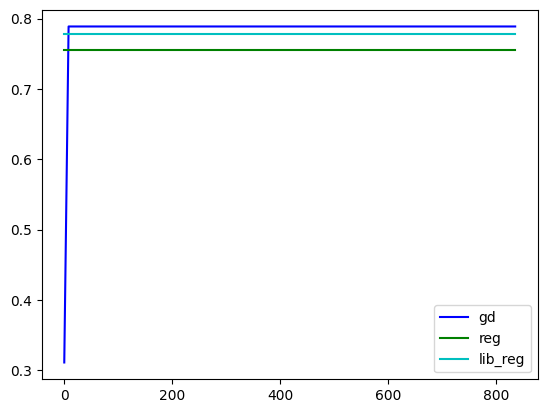

In [74]:
lib_reg_best = RidgeClassifier(**lib_reg_params)
lib_reg_best.fit(X_train, y_train)
reg_best_score = lib_reg_best.score(X_test, y_test)

curve_indices = np.linspace(0, model_gd.completed_epochs - 1, 100, dtype=int)
plt.plot(curve_indices, np.array(model_gd.score_values)[curve_indices], c='b', label='gd')
plt.plot(curve_indices, list(map(lambda _: reg_score, curve_indices)), c='g', label='reg')
plt.plot(curve_indices, list(map(lambda _: reg_best_score, curve_indices)), c='c', label='lib_reg')
plt.legend()
plt.show()

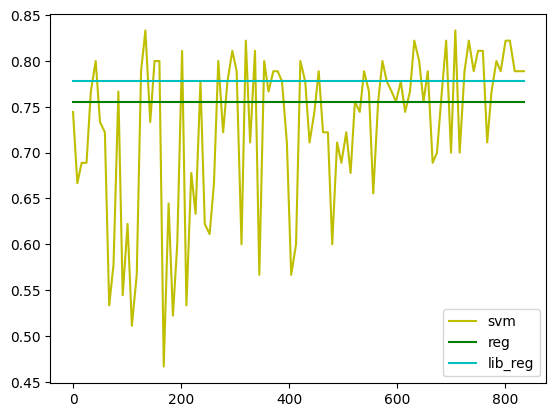

In [75]:
curve_indices = np.linspace(0, model_svm.completed_epochs - 1, 100, dtype=int)
plt.plot(curve_indices, np.array(model_svm.score_values)[curve_indices], c='y', label='svm')
plt.plot(curve_indices, list(map(lambda _: reg_score, curve_indices)), c='g', label='reg')
plt.plot(curve_indices, list(map(lambda _: reg_best_score, curve_indices)), c='c', label='lib_reg')
plt.legend()
plt.show()

In [96]:
lib_gd_best = SGDClassifier(max_iter=epochs, **lib_gd_params)
lib_gd_best.fit(X_train, y_train)

model_gd.theta, lib_gd_best.coef_

(array([ 0.16784996,  0.02914251,  0.06489907, -0.01986764, -0.25355859,
        -0.00166503, -0.04772263,  0.32849666, -0.17098509, -0.01672328,
        -0.10112297, -0.51729382, -0.37703183]),
 array([[-1.11719321e+12,  2.60903526e+12, -5.72594711e+11,
         -1.22053704e+12,  2.23824596e+11,  1.12677441e+12,
          9.79408639e+10,  6.53587191e+11,  9.72068208e+11,
          5.20544189e+11,  1.45094521e+12, -9.37891496e+11]]))

In [102]:
lib_svm_best = SVC(max_iter=epochs, **lib_svm_params)
lib_svm_best.fit(X_train, y_train)
lib_svm_best.dual_coef_

C:\Users\mi\PycharmProjects\machine-learning\venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=836).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


array([[ 2.66621752e-01, -8.71104775e-01, -4.53035810e-01, ...,
         7.35688190e-01, -6.87681906e-01,  1.08072371e+00],
       [-7.02231493e-02, -8.71104775e-01,  6.49513719e-01, ...,
         7.35688190e-01,  1.45416070e+00,  7.19360226e-01],
       [-1.58602521e+00, -8.71104775e-01, -4.95362150e-01, ...,
         7.35688190e-01, -6.87681906e-01, -7.26093707e-01],
       ...,
       [ 3.50832977e-01, -8.71104775e-01, -1.92883674e-01, ...,
         7.35688190e-01,  1.45416070e+00,  3.06373388e-01],
       [-7.02231493e-02, -8.71104775e-01,  1.65728387e-04, ...,
         7.35688190e-01,  1.45416070e+00, -1.16489222e+00],
       [-1.08075785e+00,  1.14796753e+00, -4.65424007e-01, ...,
        -1.35927151e+00, -6.87681906e-01,  8.09701096e-01]])